In [1]:
import sys 
import os
import numpy as np 
import time
import tqdm

if "google.colab" in sys.modules:
    # Move to top content folder
    while not os.getcwd().endswith("content"):
        os.chdir("..")
    # Check if repo has already been cloned
    if not os.path.exists("rl_inventory_opt"): # if not, clone it
      print("Cloning repo...")
      !git clone https://github.com/isfons/rl_inventory_opt.git
    # Set the correct working directory
    %cd rl_inventory_opt
    # Update repo
    !git pull

from algorithms import *
from IMP_CW_env import DiscreteMESCEnv
from utils import plot_reward_evolution, plot_reward_distribution

%matplotlib inline
# %matplotlib ipympl
import matplotlib.pyplot as plt

# **1. Environment definition**
[comment]: <> (https://github.com/MauroLuzzatto/Q-Learning-Demo-Play-nChain/blob/master/q_learning_notebook.ipynb)
The goal of this coursework is to find an inventory policy that learns the optimal way of placing orders, that is, the one that maximizes episodic returns. The policy model should therefore inform the decision-maker about when to place a replenishment order and the quantity to order so that customers' demand is satisfied.

Inventory optimisaiton is a sequential decision-making problem by nature. Thus, it can be modeled as a Markov Decision Process (MDP), which is the backbone of Reinforcement Learning (RL). The environment `DiscreteMSCEnv` implements the underlying mathematical model to represent multi-echelon supply chains. This coursework deals with the three-echelon supply chain depicted below.

<p align="center">
  <img src=".\SCstructure.png" alt="SupplyChainStructure" width="500"/>
</p>

In this environment, **actions** represent the **order quantity** placed by each stage of the supply chain at each time step and the **observation space** provides information about the **available storage capacity**. For the sake of simplicity, we limit both action and observation spaces to discrete values:
* Each action can take only 3 possible values.
<center>

| Index | Retailer 1 | Retailer 2 | DC |
|:--------:|:--------:|:--------:|:--------:|
| 0      | 0          | 0          | 0  |
| 1      | 10         | 10         | 50 |
| 2      | 20         | 20         | 100|
</center>

* The agent can observe only 4 possible values of the inventory position of each stage of the supply chain.
<center>

| Index | Retailer 1 | Retailer 2 | DC | Storage capacity level |
|:--------:|:--------:|:--------:|:--------:|:--------:|
| 0      | 0          | 0          | 0  | 0% |
| 1      | 20         | 20         | 50 | 33% |
| 2      | 40         | 40         | 100| 66% |
| 3      | 60         | 60         | 150| 100% |
</center>

Finally, the **reward** defined as the **profit** obtained by the entire supply chain after each period, considering that customers'demand as random variable following a Poisson distribution.
```python
reward = revenue - holding cost - fixed order cost - var order cost - penalty unsatisfied demand - penalty capacity violation
```

### **Basic usage**

Initialize the environment.

In [2]:
n_retailers = 2
n_DCs = 1
n_producers = 1 
supply_chain_structure = [[n_retailers] , [n_DCs], n_producers]
time_horizon = 4*7 # = 28 days 

# Initialize the environment
env = DiscreteMESCEnv(supply_chain_structure, num_periods = time_horizon)

Explore action and observation spaces.

In [3]:
print(f"Total number of joint actions: {env.action_space.n}")
print("First 3 joint actions:")
for i,a in enumerate(list(env.action_lookup.keys())[0:3]):
    print(f"    Index {i} matches action {a}")

print(f"\nTotal number of states: {env.observation_space.n}")
print("First 3 possible values of the observations:")
for i,a in enumerate(list(env.observation_lookup.keys())[0:3]):
    print(f"    Index {i} matches observation {a}")

Total number of joint actions: 27
First 3 joint actions:
    Index 0 matches action (0, 0, 0)
    Index 1 matches action (0, 0, 50)
    Index 2 matches action (0, 0, 100)

Total number of states: 64
First 3 possible values of the observations:
    Index 0 matches observation (np.float64(0.0), np.float64(0.0), np.float64(0.0))
    Index 1 matches observation (np.float64(0.0), np.float64(0.0), np.float64(50.0))
    Index 2 matches observation (np.float64(0.0), np.float64(0.0), np.float64(100.0))


Interact with the environment.

In [4]:
# Get current observation of the state
current_state = env.obs

# Sample a random action
random_action = env.sample_action()
# Get the index of the sampled action
random_action_idx = env.action_lookup[tuple(random_action)]

# Take action, observe reward, and move to the next state
next_state , reward , episode_done , additional_info = env.step(random_action)
print("Environment status after taking a step:")
print(f"    Period {env.current_period}\n    Random action: {random_action}\n    Next state: {next_state}\n    Reward: {reward}")

# Reset the environment (take conditions back to day 1)
env.reset()
print("\nEnvironment status after reset:")
print(f"    Period {env.current_period}\n    Current state: {env.obs}")

Environment status after taking a step:
    Period 2
    Random action: [10 10  0]
    Next state: [ 25  25 100]
    Reward: 553.0

Environment status after reset:
    Period 1
    Current state: [ 25  25 100]


# **2. Policy training**
To optimise an inventory policy, different methods can be used. 
- **Heuristic methods** that rely on classic inventory control policies, like the (s,S) policy
- **Meta-heuristic algorithms** that iteratively explore the search space by mimiking natural phenomena, like simulated annealing (SA) or particle-swarm optimisation (PSO).
- **RL-specific algorithms**, such as Q-learning or REINFORCE.

Your task is to implement the off-policy TD control algorithm known as **Q-learning** (Watkins, 1989), which is shown below in procedural form.
<figure>
<p align="center">
<img src="https://leimao.github.io/images/blog/2019-03-14-RL-On-Policy-VS-Off-Policy/q-learning.png" style="width:50%" align="center">
</p>
<figcaption align = "center"> Source: Sutton, R., & Barto, A. (2018). Reinforcement learning: an introduction. MIT Press. </figcaption>
</figure>

#### **Helper Functions**

Before getting into the actual implementation of the optimisation algorithm, two functions have been pre-coded for you:

* `greedy_policy` --> selects action with highest action value Q(s,a).
* `epsilon_greedy_policy` --> samples a random action with probability $\varepsilon$ and follows a greedy policy with probability $(1-\varepsilon)$.

Note that we will use both of these function to evaluate your submission. Should you wish to use a different sampling function, you have to define it **WITHIN** your algorithm!

In [5]:
def greedy_policy(env, state_idx, Q): 
    # Get index of the optimal action
    action_idx = np.argmax(Q[state_idx,:])
    # Map action index to actual action value
    return np.array(list(env.action_lookup.keys())[action_idx]) , action_idx

def epsilon_greedy_policy(env, state, Q, epsilon):
    if np.random.rand() < epsilon:
        # Explore: choose a random action
        action = env.sample_action()
        return action , env.action_lookup[tuple(action)]
    else:
        # Exploit: choose best action 
        return greedy_policy(env,state,Q)

### **Implementation**

The function `q_learning_alg` contains a basic implementation of Q-learning algorithm and returns two objects:
* `Q_table`: optimal Q(s,a) table
* `plot_info`: data to plot the learning curve.

Participants are encouraged to improve the existing code and enhance performance. As a suggestion, some improvements that can be included are: 
* Tuning default values of hyperparameters 
* Adding new features (e.g., learning rate decay or iteratively reducing $\varepsilon$)

Participants are free to modify the code as long as they **respect the structure of the template** and limit the use of Python packages to `numpy` (called as `np`). This is vital to ensure compliance with our testing platform. 

Note that we will test your implementation on a different environment and with a **limited budget**. In the final evaluation, `max_episodes` and `max_time` will be limited to 500 iterations or episodes and 15 s, respectively.

In [6]:
def q_learning_alg( env,*, 
                    max_episodes = 500 , # Total training episodes
                    max_time = 15 , # Maximum execution time
                    epsilon = 0.5 , # Probability of taking a random action
                    alpha = 0.0001, # Learning rate
                    gamma = 0.99, # Discount factor
                    seed = 0
                    ): 
    
    # Fix seed for reproducibility across runs
    np.random.seed(seed)

    # Create buffer to store plot data
    plot_data = {}
    plot_data["episode"] = []
    plot_data["total_reward"] = [] 

    # Start timer
    start_time = time.time()
    # -----------------------------------------------------------------------------------
    # PLEASE DO NOT MODIFY THE CODE ABOVE THIS LINE
    # -----------------------------------------------------------------------------------
    
    # Initialize Q-table
    action_size = env.action_space.n
    state_size  = env.observation_space.n
    Q_table = np.zeros((state_size,action_size))

    # Optimization loop
    for episode in tqdm(range(max_episodes)):
        # Reset environment
        env.reset()
        state = env.obs
        state_idx = env.observation_lookup[tuple(state)]
        done = False
        
        total_reward = 0

        while not done:
            # Chose action from behaviour policy
            action, action_idx = epsilon_greedy_policy(env, state_idx, Q_table, epsilon)
            # Take action
            next_state, reward, done , _ = env.step(action)
            next_state_idx = env.observation_lookup[tuple(next_state)]

            # Update Q_table
            _ , next_action_idx = greedy_policy(env, next_state_idx, Q_table)
            td_error = reward + gamma * Q_table[next_state_idx,next_action_idx] - Q_table[state_idx,action_idx]
            Q_table[state_idx,action_idx] += alpha * td_error

            # Update state
            state , state_idx = next_state , next_state_idx

    # -----------------------------------------------------------------------------------
    # PLEASE DO NOT MODIFY THE CODE BELOW THIS LINE
    # -----------------------------------------------------------------------------------
            # Update counter
            total_reward += reward

            # Check execution time
            if (time.time() - start_time) > max_time:
                print("Timeout reached.\n   Returning best Q(s,a) table found so far.")
                return Q_table , plot_data 
        
        # print(f"Episode: {episode + 1}, Total Reward: {total_reward}")
        plot_data["episode"].append(episode)
        plot_data["total_reward"].append(total_reward)

    return Q_table , plot_data

To learn the optimal Q-table, run the cell below. Remember that, if you modify the function `q_learning_alg`, the previous cell should be re-run before starting the training process.

In [7]:
Q_table, plot_info = q_learning_alg(env,
                                    max_episodes = 500 , # Total training episodes
                                    max_time = 15 , # Maximum execution time
                                    epsilon = 0.25 , # Probability of taking a random action
                                    alpha = 0.001, # Learning rate
                                    gamma = 0.99, # Discount factor
                                    )

100%|██████████| 500/500 [00:11<00:00, 45.16it/s]


Plot learning curve.

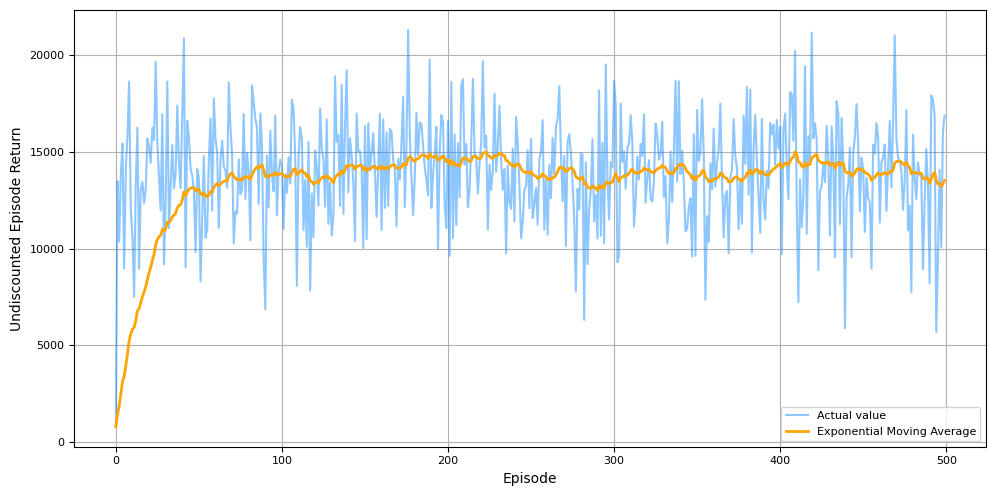

In [8]:
plot_reward_evolution(plot_info["episode"],plot_info["total_reward"], xlabel="Episode", ylabel="Undiscounted Episode Return")

# **5. Policy evaluation**
### **5.1. Test data**: get new demand scenarios
The variable test_demand_dataset contains 50 samples of demand scenarios, each with `env.n_periods` days, that will be used for testing and comparing the extrapolation capabilities of the different policies.

In [9]:
import pickle
# Open the file in binary mode
path = os.path.join("benchmarking", "test_dataset.pickle")
with open(path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    test_demand_dataset = pickle.load(file)

### **5.2. Evaluation**
To evaluate the optimal inventory control policy, we will use the $Q^*(s,a)$ table to always choose the best action $a$ for a given state $s$. The function `evaluate_action_value_function` computes the total undiscounted return of each episode in `test_demand_dataset` following the policy given by `Q_table` and returns a list with the result of each episode.

In [10]:
def evaluate_action_value_function(env, demand_dataset, Q_table):

    # Initialize buffer list to store results of each run
    reward_list = []

    # Run each episode and compute total undiscounted reward
    for scenario in demand_dataset:
        # Fix customer demand (if provided)
        env.demand_dataset = scenario

        # Reset environment before running each episode
        env.reset()
        done = False

        # Initialize reward counter
        total_reward = 0
        
        while not done:
            # Get current state and its index in the Q(s,a) table
            state = env.obs
            state_idx = env.observation_lookup[tuple(state)]

            # Get action according to the greedy policy
            action , _ = greedy_policy(env, state_idx, Q_table)
            
            # Interact with the environment to get reward and next state
            state , reward, done, _ = env.step(action)
            total_reward += reward
            
        reward_list.append(total_reward)

    print("Performance of the inventory management policy in the test set:\n - Average reward: {:.0f}\n - Reward standard deviation: {:.2f}".format(np.mean(reward_list), np.std(reward_list)))
    
    return reward_list

In [11]:
reward_list = evaluate_action_value_function(env, test_demand_dataset, Q_table)

Performance of the inventory management policy in the test set:
 - Average reward: 14599
 - Reward standard deviation: 1458.28


##### **Results visualization**

Plot the distribution of rewards and compare your results to those obtained with other benchmarking poilicies, which have been evaluated using the same `test_demand_dataset`. 

The policies considered for benchmarking are:
* A neural network whose weights have been optimized using the algorithm **simulated annealing**.
* A neural network whose weights have been optimized using a **local search** algorithm.
* An **(s,S) policy**, which is a simple heuristic strategy where an order is placed to bring the inventory up to a target maximum level *S* only when the on-hand inventory, or inventory position, falls to or below a reorder point *s*.

In [12]:
from common import DiscretePolicyNetwork, evaluate_policy
import torch

benchmarking_policies = ['local_search','simulated_annealing']
distributions = {k: None for k in benchmarking_policies}

policy = DiscretePolicyNetwork(input_size=env.observation_space.shape[0], 
                               output_size=env.action_space.n,
                                )
for alg in benchmarking_policies:
    path = os.path.join("benchmarking","policy_"+ alg + ".pt")
    policy.load_state_dict(torch.load(path))
    distributions[alg] = evaluate_policy(policy, env, test_demand_dataset)
    print("Performance of the {} policy in the test set:\n - Average reward: {:.0f}\n - Reward standard deviation: {:.2f}".format(alg,np.mean(distributions[alg]), np.std(distributions[alg])))  

Performance of the local_search policy in the test set:
 - Average reward: 21424
 - Reward standard deviation: 1936.83
Performance of the simulated_annealing policy in the test set:
 - Average reward: 21882
 - Reward standard deviation: 1524.94


In [13]:
sSpolicy = HeuristicPolicy()
sSpolicy.policy_param = np.array([24., 37., 14., 50., 23., 79.])
distributions['heuristic (s,S)'] = sSpolicy.evaluate_policy(env, test_demand_dataset) # Not added to reward distribution plot for better visualization
print("Performance of the (s,S) policy in the test set:\n - Average reward: {:.0f}\n - Reward standard deviation: {:.2f}".format(np.mean(distributions['heuristic (s,S)']), np.std(distributions['heuristic (s,S)'])))

Performance of the (s,S) policy in the test set:
 - Average reward: 5120
 - Reward standard deviation: 104.86


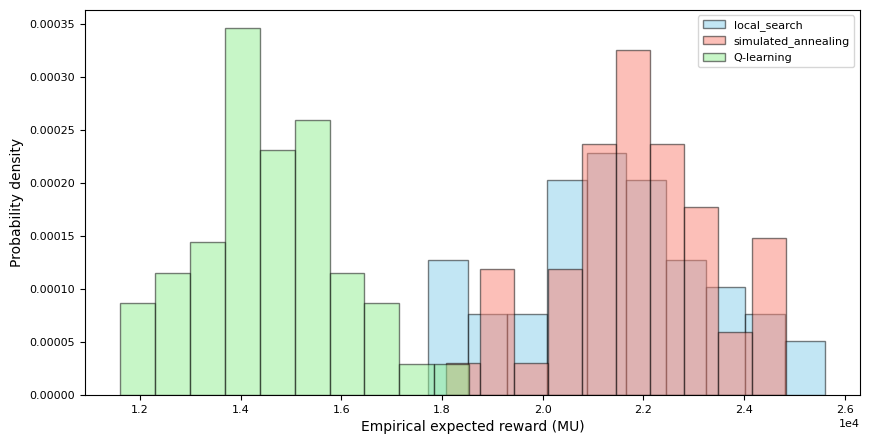

In [14]:
distributions["Q-learning"] = reward_list
distributions.pop("heuristic (s,S)") # Remove before plotting for better visualization
plot_reward_distribution(np.vstack([distributions[alg] for alg in distributions.keys()]).T, labels = list(distributions.keys()))


## **Submission**

Once participants have fine tuned their implementation of Q-learning algorithm, they must submit their function `q_learning_alg` following these guidelines:
* If hyperparameter values were tuned, make sure to set their optimal values as default when defining the function. For example:
```python
    def q_learning_alg( env,*, 
                    max_episodes = 500 , 
                    max_time = 5 ,
                    epsilon = 0.5 , 
                    alpha = 10, # --> CHANGED FROM 0.0001 TO 10
                    gamma = 0.99, 
                    seed = 0
                    ): 
```
* Copy the content of [cell 13](inventory_management_RL_GoogleColab.ipynb#implementation) and upload it using [this link](https://rl-inventory-submission.streamlit.app/).